In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
from pymc3.distributions.timeseries import GaussianRandomWalk
import seaborn as sns
from statsmodels import datasets
from theano import tensor as T

In [2]:
df = datasets.get_rdataset('mastectomy', 'HSAUR', cache=True).data
df.event = df.event.astype(np.int64)
df.metastized = (df.metastized == 'yes').astype(np.int64)
n_patients = df.shape[0]
patients = np.arange(n_patients)

In [3]:
df.head()

,time,event,metastized
0,23,1,0
1,47,1,0
2,69,1,0
3,70,0,0
4,100,0,0


In [4]:
n_patients

44

Each row represents observations from a woman diagnosed with breast cancer that underwent a mastectomy. The column time represents the time (in months) post-surgery that the woman was observed. The column event indicates whether or not the woman died during the observation period. The column metastized represents whether the cancer had metastized prior to surgery.

This tutorial analyzes the relationship between survival time post-mastectomy and whether or not the cancer had metastized.

In [5]:
df.event.mean()


0.59090909090909094

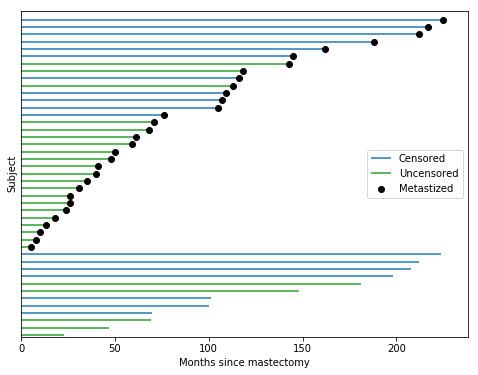

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))

blue, _, red = sns.color_palette()[:3]

ax.hlines(patients[df.event.values == 0], 0, df[df.event.values == 0].time,
          color=blue, label='Censored')

ax.hlines(patients[df.event.values == 1], 0, df[df.event.values == 1].time,
          color=red, label='Uncensored')

ax.scatter(df[df.metastized.values == 1].time, patients[df.metastized.values == 1],
           color='k', zorder=10, label='Metastized')

ax.set_xlim(left=0)
ax.set_xlabel('Months since mastectomy')
ax.set_yticks([])
ax.set_ylabel('Subject')

ax.set_ylim(-0.25, n_patients + 0.25)

ax.legend(loc='center right');
plt.show()

In order to perform Bayesian inference with the Cox model, we must specify priors on $\beta$ and $h_0(t)$. We place a normal prior on $\beta$, $\beta \sim N(\mu_{\beta}, \sigma^2_{\beta})$, where $\mu_{\beta} \sim N(0, 10^2)$ and $\sigma_{\beta} \sim U(0, 10)$.

A suitable prior on $h_0(t)$ is less obvious. We choose a semiparametric prior, where $h_0(t) = h_j$ if $x_j \leq t < s_{j+1}$. With $h_0(t)$ constrained to have this form, all we need to do is choose priors for the $N-1$ values $h_j$. We use independent priors $h_j \sim Gammma(10^{-2}, 10^{-2}).$ For our mastectomy example, we make each interval three months long.

In [13]:
interval_length = 3
interval_bounds = np.arange(0, df.time.max() + interval_length + 1, interval_length)
interval_bounds

array([  0,   3,   6,   9,  12,  15,  18,  21,  24,  27,  30,  33,  36,
        39,  42,  45,  48,  51,  54,  57,  60,  63,  66,  69,  72,  75,
        78,  81,  84,  87,  90,  93,  96,  99, 102, 105, 108, 111, 114,
       117, 120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150, 153,
       156, 159, 162, 165, 168, 171, 174, 177, 180, 183, 186, 189, 192,
       195, 198, 201, 204, 207, 210, 213, 216, 219, 222, 225, 228])

In [16]:
n_intervals = interval_bounds.size - 1 ## 76
intervals = np.arange(n_intervals)
#n_intervals

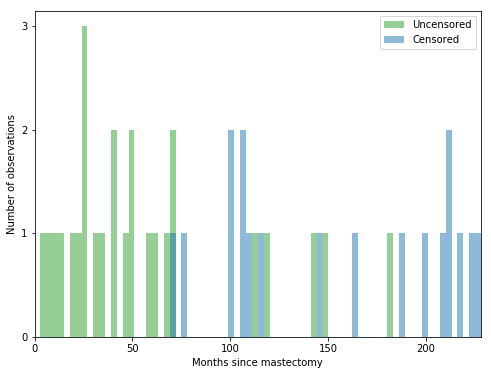

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(df[df.event == 1].time.values, bins=interval_bounds,
        color=red, alpha=0.5, lw=0,
        label='Uncensored');
ax.hist(df[df.event == 0].time.values, bins=interval_bounds,
        color=blue, alpha=0.5, lw=0,
        label='Censored');

ax.set_xlim(0, interval_bounds[-1]);
ax.set_xlabel('Months since mastectomy');

ax.set_yticks([0, 1, 2, 3]);
ax.set_ylabel('Number of observations');

ax.legend();
plt.show()

In [11]:
last_period = np.floor((df.time - 0.01) / interval_length).astype(int)

death = np.zeros((n_patients, n_intervals))
death[patients, last_period] = df.event

In [24]:
exposure = np.greater_equal.outer(df.time, interval_bounds[:-1]) * interval_length
exposure

array([[3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       ..., 
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 3, 3, 3]])

In [25]:
exposure[patients, last_period] = df.time - interval_bounds[last_period]
exposure

array([[3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       ..., 
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 3, 3, 3]])

In [18]:
SEED = 5078864 # from random.org


In [20]:
with pm.Model() as model:

    lambda0 = pm.Gamma('lambda0', 0.01, 0.01, shape=n_intervals)

    beta = pm.Normal('beta', 0, sd=1000)

    lambda_ = pm.Deterministic('lambda_', T.outer(T.exp(beta * df.metastized), lambda0))
    mu = pm.Deterministic('mu', exposure * lambda_)

    obs = pm.Poisson('obs', mu, observed=death)

In [21]:
n_samples = 1000
n_tune = 1000

In [22]:
with model:
    trace = pm.sample(n_samples, tune=n_tune, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 1999/2000 [02:37<00:00, 12.68it/s]/home/jonathan/miniconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 68 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 2000/2000 [02:37<00:00, 12.68it/s]


In [23]:
np.exp(trace['beta'].mean())

2.1302253944313287

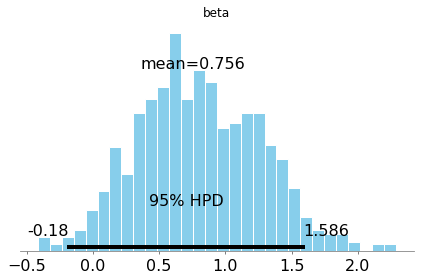

In [28]:
pm.plot_posterior(trace, varnames=['beta'], color='#87ceeb');
plt.show()

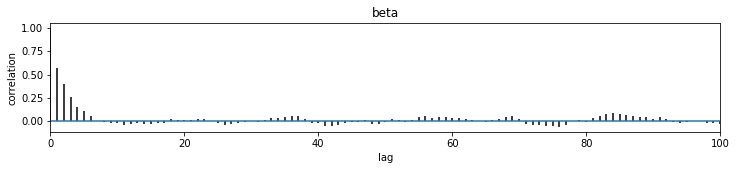

In [29]:
pm.autocorrplot(trace, varnames=['beta']);
plt.show()

In [31]:
# We now examine the effect of metastization on both the 
# cumulative hazard and on the survival function.
base_hazard = trace['lambda0']
met_hazard = trace['lambda0'] * np.exp(np.atleast_2d(trace['beta']).T)

In [32]:

def cum_hazard(hazard):
    return (interval_length * hazard).cumsum(axis=-1)

def survival(hazard):
    return np.exp(-cum_hazard(hazard))

In [35]:
def plot_with_hpd(x, hazard, f, ax, color=None, label=None, alpha=0.05):
    mean = f(hazard.mean(axis=0))

    percentiles = 100 * np.array([alpha / 2., 1. - alpha / 2.])
    hpd = np.percentile(f(hazard), percentiles, axis=0)

    ax.fill_between(x, hpd[0], hpd[1], color=color, alpha=0.25)
    ax.step(x, mean, color=color, label=label);
    

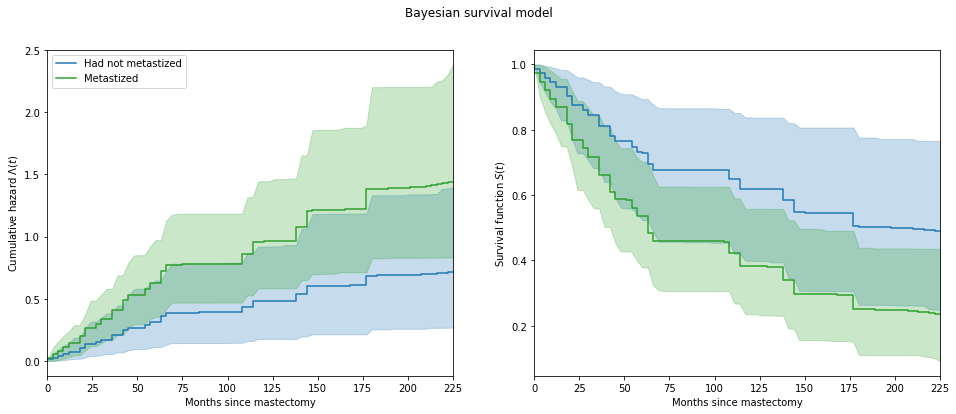

In [36]:
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

plot_with_hpd(interval_bounds[:-1], base_hazard, cum_hazard,
              hazard_ax, color=blue, label='Had not metastized')
plot_with_hpd(interval_bounds[:-1], met_hazard, cum_hazard,
              hazard_ax, color=red, label='Metastized')

hazard_ax.set_xlim(0, df.time.max());
hazard_ax.set_xlabel('Months since mastectomy');

hazard_ax.set_ylabel(r'Cumulative hazard $\Lambda(t)$');

hazard_ax.legend(loc=2);

plot_with_hpd(interval_bounds[:-1], base_hazard, survival,
              surv_ax, color=blue)
plot_with_hpd(interval_bounds[:-1], met_hazard, survival,
              surv_ax, color=red)

surv_ax.set_xlim(0, df.time.max());
surv_ax.set_xlabel('Months since mastectomy');

surv_ax.set_ylabel('Survival function $S(t)$');

fig.suptitle('Bayesian survival model');
plt.show()

We see that the cumulative hazard for metastized subjects increases more rapidly initially (through about seventy months), after which it increases roughly in parallel with the baseline cumulative hazard.

These plots also show the pointwise 95% high posterior density interval for each function. One of the distinct advantages of the Bayesian model fit with pymc3 is the inherent quantification of uncertainty in our estimates.